## Testing Zone

Original Captions:
-  Two young guys with shaggy hair look at their hands while hanging out in the yard.
-  Two young, White males are outside near many bushes.
-  Two men in green shirts are standing in a yard.
-  A man in a blue shirt standing in a garden.
-  Two friends enjoy time spent together.


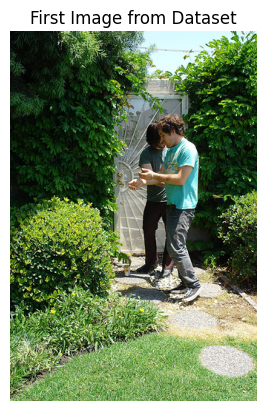


Simulated Tokenized Caption (using SimpleVocab):
[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 4, 5, 21, 22, 23, 24, 25, 26, 27, 28, 20, 4, 29, 17, 30, 31, 24, 32, 17, 33, 19, 20, 33, 34, 17, 33, 35, 36, 32, 17, 33, 37, 20, 4, 38, 39, 40, 41, 42, 20, 3]

Corresponding Words (using SimpleVocab):
['[CLS]', 'two', 'young', 'guys', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hands', 'while', 'hanging', 'out', 'in', 'the', 'yard', '.', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', 'two', 'men', 'in', 'green', 'shirts', 'are', 'standing', 'in', 'a', 'yard', '.', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'standing', 'in', 'a', 'garden', '.', 'two', 'friends', 'enjoy', 'time', 'spent', 'together', '.', '[SEP]']


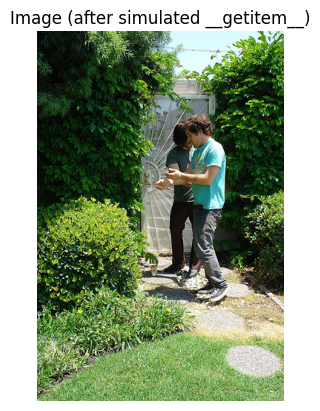


If the printed captions, tokenized captions, corresponding words, and the two images match,
then it's a good indication that your ImageCaptionDataset and DataLoader are likely parsing
the images and captions correctly.


In [3]:
from datasets import load_dataset
from PIL import Image
from transformers import BertTokenizer
import matplotlib.pyplot as plt

# Load the dataset (select only the first sample for this example)
flickr_dataset = load_dataset("nlphuji/flickr30k", split="test").select(range(1))

# Extract the first image and its captions
try:
    first_image = flickr_dataset[0]["image"]
    first_image_captions = flickr_dataset[0]["caption"]
except Exception as e:
    print(f"Error accessing data: {e}")
    exit()

# Print the captions
print("Original Captions:")
for cap in first_image_captions:
    print("- ", cap)

# Display the image
plt.imshow(first_image)
plt.axis("off")
plt.title("First Image from Dataset")
plt.show()

# --- Now, let's simulate what the ImageCaptionDataset and DataLoader would do ---

# 1. Initialize Tokenizer (same as in your main code)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 2. Build a simplified Vocabulary (for demonstration purposes)
# In your actual code, you build a more sophisticated vocabulary, but here we'll just
# manually create a small one to illustrate the process.
class SimpleVocab:
    def __init__(self, tokenizer):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.tokenizer = tokenizer

        # Add special tokens
        for special_token in [tokenizer.pad_token, tokenizer.unk_token, tokenizer.cls_token, tokenizer.sep_token]:
            if special_token is not None:
                self.add_word(special_token)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx.get(self.tokenizer.unk_token, 0)
        return self.word2idx[word]
    
    def __len__(self):
        return len(self.word2idx)

# Create an instance of the simple vocabulary
vocab = SimpleVocab(tokenizer)

# Manually add some words from the first image's captions to the vocabulary
for cap in first_image_captions:
    tokens = tokenizer.tokenize(cap.lower())
    for token in tokens:
        vocab.add_word(token)


# 3. Simulate ImageCaptionDataset's __getitem__
def simulate_getitem(image, caption_list, tokenizer, vocab):
    # Tokenize and vectorize caption
    combined_caption = " ".join(caption_list)
    tokens = tokenizer.tokenize(str(combined_caption).lower())
    caption_vec = [vocab(tokenizer.cls_token)]
    caption_vec.extend([vocab(token) for token in tokens])
    caption_vec.append(vocab(tokenizer.sep_token))

    print("\nSimulated Tokenized Caption (using SimpleVocab):")
    print(caption_vec)

    print("\nCorresponding Words (using SimpleVocab):")
    print([vocab.idx2word.get(idx, tokenizer.unk_token) for idx in caption_vec])

    return image, caption_vec

# Call the simulation function
simulated_image, simulated_caption_vec = simulate_getitem(
    first_image, first_image_captions, tokenizer, vocab
)

# 4. Display the image again (for verification)
plt.imshow(simulated_image)
plt.axis("off")
plt.title("Image (after simulated __getitem__)")
plt.show()

print("\nIf the printed captions, tokenized captions, corresponding words, and the two images match,")
print("then it's a good indication that your ImageCaptionDataset and DataLoader are likely parsing")
print("the images and captions correctly.")

Based on the previous results and the analysis, the following classes and functions in your original code are primarily responsible for ensuring that captions and images are correctly parsed and associated for the model during training:

**1. `ImageCaptionDataset` class:**

   *   **`__init__`:**
        *   Stores the `images` and `captions` lists, which maintain the one-to-one correspondence between images and their captions based on their indices.
        *   Initializes the `tokenizer` and `vocab` used for text processing.
   *   **`__getitem__`:**
        *   Retrieves the image and its corresponding caption list using the provided index (`idx`).
        *   Combines multiple captions for an image into a single string using `" ".join(caption_list)`.
        *   Tokenizes the combined caption using `self.tokenizer.tokenize()`.
        *   Converts the tokens into their numerical representations (indices) using `self.vocab`.
        *   Returns the processed `image` and the `target` (vectorized caption).

**2. `custom_collate_fn` function:**

   *   Takes a `batch` of data (a list of `(image, target)` tuples from `ImageCaptionDataset`) as input.
   *   Unpacks the `batch` into separate lists of `images` and `captions`.
   *   Stacks the `images` into a single tensor using `torch.stack(images)`.
   *   Pads the `captions` to the same length within the batch using `pad_sequence`. This is essential for batch processing in Transformers.
   *   Creates a `caption_mask` that indicates which elements of the padded captions are actual tokens (True) and which are padding (False).
   *   Returns the `images`, `captions_padded`, and `caption_mask` as a tuple. This is the format expected by the model during training.

**3. `DataLoader` class (PyTorch):**

   *   Although not explicitly defined in your code, the `DataLoader` is a crucial PyTorch class that uses the `ImageCaptionDataset` and `custom_collate_fn` to create and provide batches of data during training.
   *   It shuffles the data (if `shuffle=True`), handles batching, and ensures that the correct data is fed to the model in each iteration.

**4. `Vocabulary` class:**
    *   **`__init__`:** Initializes the vocabulary with special tokens (pad, unknown, start, end) from the tokenizer.
    *   **`add_word`:** Adds a word to the vocabulary if not present, assigning a unique index.
    *   **`__call__`:** Retrieves the index of a given word, returning the index for the unknown token if the word is not found.

**In essence:**

*   `ImageCaptionDataset` handles the loading, preprocessing, and pairing of individual images and captions.
*   `custom_collate_fn` prepares batches of images and captions in the correct format for the model.
*   `DataLoader` orchestrates the batching process and provides the data to the training loop.
*   `Vocabulary` manages the mapping between words and their numerical representations.

These components work together to ensure that the model receives the correct pairings of images and their corresponding captions during the training process, allowing it to learn the associations between visual and textual information.


# Fusion Transformer

Okay, let's analyze how the improved `FusionTransformer` model associates captions to images as input, focusing on the key changes you've made.

**Key Changes in the Improved `FusionTransformer`**

1.  **Cross-Attention Mechanism:**
    *   You've introduced a `cross_attention` layer (using `nn.MultiheadAttention`). This is a crucial addition for multimodal fusion.
    *   In the `forward` pass:
        *   `query` is derived from the `caption_embeddings` (the decoder's input).
        *   `key` and `value` are derived from the `img_features` (the encoder's output).
    *   This allows the decoder to attend to specific parts of the image, guided by the current state of the caption being generated.

2.  **Combined Features for Decoding:**
    *   The output of the `cross_attention` layer (`attended_features`) is added to the `caption_embeddings`.
    *   This `combined_features` tensor is then fed as the `tgt` (target) to the `transformer_decoder`.
    *   Effectively, the decoder now has information from both the caption (via embeddings) and relevant image regions (via cross-attention).

3.  **Positional Encoding for Decoding:**
    *   You add positional encodings (`self.pos_embed`) to the `caption_embeddings` before they are used in the cross-attention and decoder. This helps the model understand the order of words in the caption.

**Simplified Explanation of How the Model Associates Captions and Images**

1.  **Image Feature Extraction:**
    *   The `EncoderViT` (which remains unchanged) takes an image as input and produces `img_features`. These features represent a high-level, abstract understanding of the image's content, broken down into different regions (patches).

2.  **Caption Preprocessing:**
    *   The input caption is tokenized, and each token is converted into its numerical representation (word embedding) using `self.word_embed`.
    *   Positional encodings are added to these embeddings to provide information about the word order.

3.  **Cross-Attention (The Core of the Association):**
    *   The `cross_attention` layer is where the magic happens. It takes the caption embeddings (as the `query`) and the image features (as `key` and `value`).
    *   **Analogy:** Imagine you're describing an image. As you say each word, you naturally look at the part of the image that's most relevant to that word. Cross-attention mimics this process.
    *   **Mechanism:** The `query` (from the caption) is compared to the `key` (from the image) to calculate attention scores. These scores determine how much each part of the image should be emphasized based on the current word being generated. The `value` (also from the image) is then weighted by these attention scores to produce the `attended_features`.
    *   **Output:** `attended_features` is a representation of the image that is now "filtered" or "highlighted" based on the information in the caption.

4.  **Combined Feature Decoding:**
    *   The `attended_features` (image information relevant to the caption) are added to the `caption_embeddings`.
    *   The `transformer_decoder` takes this combined representation and generates the output sequence (the caption). The decoder uses its internal self-attention mechanism along with the provided `tgt_mask` (to prevent it from "looking ahead" at future words) to produce the caption, one word at a time.

5.  **Output Layer:**
    *   Finally, `self.fc_out` (a linear layer) transforms the decoder's output into a probability distribution over the vocabulary, and the word with the highest probability is selected as the next word in the caption.

**In essence, the improved `FusionTransformer` uses cross-attention to dynamically link parts of the image to specific words in the caption. The decoder then uses this combined information to generate a caption that is conditioned on both the image content and the previously generated words.**

**Simplified Example:**

Let's say the image is of a "cat sitting on a mat."

1.  `EncoderViT` produces features representing the entire image.
2.  The caption starts with "[CLS]".
3.  **Cross-Attention:**
    *   `query`: Embedding of "[CLS]".
    *   `key`, `value`: Image features.
    *   The attention mechanism might give high scores to regions containing the cat and the mat because these are likely to be relevant at the beginning of the caption.
    *   `attended_features`: A representation of the image emphasizing the cat and mat regions.
4.  **Decoder:**
    *   The decoder receives the combined features (embedding of "[CLS]" + `attended_features`).
    *   It might predict "cat" as the next word.
5.  The process repeats:
    *   `query`: Embedding of "cat".
    *   Cross-attention now focuses on image regions related to "cat" (maybe more on the cat than the mat).
    *   The decoder might predict "sitting".
    *   And so on...

This is a highly simplified illustration, but it captures the core idea of how cross-attention allows the model to associate words in the caption with relevant regions in the image during the generation process.


## Model creation

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rusla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rusla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Vocabulary saved.


C:\Users\rusla\AppData\Local\Temp\ipykernel_26768\1766584550.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  captions = [torch.tensor(caption) for caption in captions]
c:\Users\rusla\.conda\envs\multimodal\Lib\site-packages\torch\nn\functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1/50, Batch: 1/4, Batch Loss: 6.1622
Epoch: 1/50, Batch: 2/4, Batch Loss: 6.1392
Epoch: 1/50, Batch: 3/4, Batch Loss: 6.0279
Epoch: 1/50, Batch: 4/4, Batch Loss: 5.9304
Epoch: 2/50, Batch: 1/4, Batch Loss: 5.6508
Epoch: 2/50, Batch: 2/4, Batch Loss: 5.5747
Epoch: 2/50, Batch: 3/4, Batch Loss: 5.3874
Epoch: 2/50, Batch: 4/4, Batch Loss: 5.2986
Epoch: 3/50, Batch: 1/4, Batch Loss: 5.2534
Epoch: 3/50, Batch: 2/4, Batch Loss: 5.1572
Epoch: 3/50, Batch: 3/4, Batch Loss: 4.9391
Epoch: 3/50, Batch: 4/4, Batch Loss: 4.7882
Epoch: 4/50, Batch: 1/4, Batch Loss: 4.8866
Epoch: 4/50, Batch: 2/4, Batch Loss: 4.7171
Epoch: 4/50, Batch: 3/4, Batch Loss: 4.6220
Epoch: 4/50, Batch: 4/4, Batch Loss: 4.4835
Epoch: 5/50, Batch: 1/4, Batch Loss: 4.4955
Epoch: 5/50, Batch: 2/4, Batch Loss: 4.4599
Epoch: 5/50, Batch: 3/4, Batch Loss: 4.3796
Epoch: 5/50, Batch: 4/4, Batch Loss: 4.2652
Epoch: 6/50, Batch: 1/4, Batch Loss: 4.1055
Epoch: 6/50, Batch: 2/4, Batch Loss: 4.1964
Epoch: 6/50, Batch: 3/4, Batch L

C:\Users\rusla\AppData\Local\Temp\ipykernel_26768\1766584550.py:379: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fusion_transformer = torch.load("fusion_transformer.pth")


Testing on a training image:


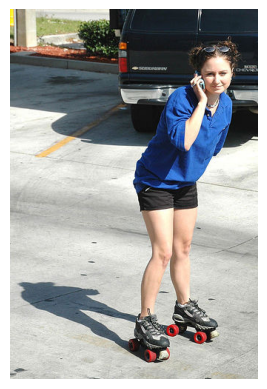

Generated Caption: same leash buildings gray tied phone bushes young performing form is tunes pavement ' ear painted ##less clothes
Expected Captions:
-  A girl is on rollerskates talking on her cellphone standing in a parking lot.
-  A trendy girl talking on her cellphone while gliding slowly down the street.
-  A young adult wearing rollerblades, holding a cellular phone to her ear.
-  There is a young girl on her cellphone while skating.
-  Woman talking on cellphone and wearing rollerskates.

Testing on a validation image:


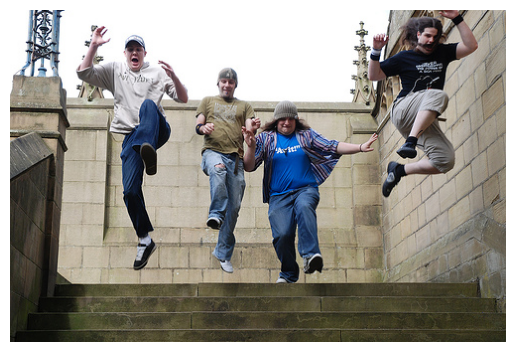

Generated Caption: woman rig it colored cruises green ##ska stairway food rail a a a a a time
Expected Captions:
-  Three young men and a young woman wearing sneakers are leaping in midair at the top of a flight of concrete stairs.
-  Four casually dressed guys jumping down a stairway outdoors with a stone wall behind them.
-  Four guys three wearing hats one not are jumping at the top of a staircase.
-  Four men with excited faces are jumping down from the top of stairs.
-  Four people are jumping from the top of a flight of stairs.

Testing on a test image:


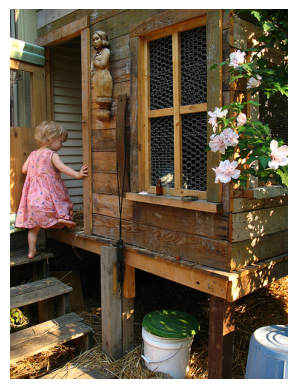

Generated Caption: two two two two two two bun white ##rin white white pig another men blue working cleaning ##pa middle
Expected Captions:
-  A child in a pink dress is climbing up a set of stairs in an entry way.
-  A little girl in a pink dress going into a wooden cabin.
-  A little girl climbing the stairs to her playhouse.
-  A little girl climbing into a wooden playhouse.
-  A girl going into a wooden building.


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from datasets import load_dataset
import math
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, ViTModel, BertModel
import matplotlib.pyplot as plt

# --- Data Loading and Preprocessing ---


def custom_collate_fn(batch):
    images, captions = zip(*batch)

    # Stack images into a batch tensor
    images = torch.stack(images)

    # Pad captions to the same length
    captions = [torch.tensor(caption) for caption in captions]
    captions_padded = pad_sequence(captions, batch_first=True, padding_value=0)  # Use padding token index (e.g., 0)

    # Create caption mask
    caption_mask = (captions_padded != 0)  # True for valid tokens, False for padding

    return images, captions_padded, caption_mask


class ImageCaptionDataset(Dataset):
    def __init__(self, images, captions, tokenizer, vocab, transform=None):
        self.images = images
        self.captions = captions
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Preprocess image
        image = self.images[idx].convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Tokenize and vectorize caption
        caption_list = self.captions[idx]
        combined_caption = " ".join(caption_list)
        tokens = self.tokenizer.tokenize(str(combined_caption).lower())
        caption_vec = [self.vocab(self.tokenizer.cls_token)]
        caption_vec.extend([self.vocab(token) for token in tokens])
        caption_vec.append(self.vocab(self.tokenizer.sep_token))
        target = torch.LongTensor(caption_vec)

        return image, target


class Vocabulary:
    def __init__(self, tokenizer):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.tokenizer = tokenizer  # Store the tokenizer

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx.get(self.tokenizer.unk_token, 0)  # Use tokenizer's unk_token
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


def build_vocab(captions_list, threshold=1, tokenizer=None):
    if tokenizer is None:
        raise ValueError("A tokenizer must be provided to build the vocabulary.")

    # Count the frequency of each token
    counter = {}
    for captions in captions_list:
        for caption in captions:
            tokens = tokenizer.tokenize(str(caption).lower())
            for word in tokens:
                counter[word] = counter.get(word, 0) + 1

    # Initialize the vocabulary
    vocab = Vocabulary(tokenizer)

    # Add special tokens from the tokenizer
    for special_token in [tokenizer.pad_token, tokenizer.unk_token, tokenizer.cls_token, tokenizer.sep_token]:
        if special_token is not None:
            vocab.add_word(special_token)

    # Add words that meet the frequency threshold
    words = [word for word, cnt in counter.items() if cnt >= threshold]
    for word in words:
        if word not in vocab.word2idx:  # Avoid duplicates
            vocab.add_word(word)

    return vocab


class EncoderViT(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.config = self.vit.config
        self.linear = nn.Linear(self.config.hidden_size, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        for param in self.vit.parameters():
            param.requires_grad = False

    def forward(self, images):
        with torch.no_grad():
            features = self.vit(images).last_hidden_state
        features = features[:, 0, :]
        features = self.bn(self.linear(features))
        return features


class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, dropout_p=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_p)

        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


import math
import torch
import torch.nn as nn


class FusionTransformer(nn.Module):
    def __init__(self, embed_size, num_heads, num_layers, vocab_size, vocab, tokenizer, dropout_p=0.1):
        super().__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        self.vocab = vocab
        self.tokenizer = tokenizer

        # Positional Encoding
        self.pos_embed = PositionalEncoding(embed_size, dropout_p)

        # Word Embeddings
        self.word_embed = nn.Embedding(vocab_size, embed_size)

        # Transformer Components
        self.transformer_encoder = self._create_transformer_encoder(embed_size, num_heads, num_layers, dropout_p)
        self.transformer_decoder = self._create_transformer_decoder(embed_size, num_heads, num_layers, dropout_p)

        # Cross-Attention Layer
        self.cross_attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads, dropout=dropout_p, batch_first=True)

        # Output Layer
        self.fc_out = nn.Linear(embed_size, vocab_size)

    def _create_transformer_encoder(self, embed_size, num_heads, num_layers, dropout_p):
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_size, nhead=num_heads, dim_feedforward=embed_size * 4, dropout=dropout_p, batch_first=True
        )
        return nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def _create_transformer_decoder(self, embed_size, num_heads, num_layers, dropout_p):
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size, nhead=num_heads, dim_feedforward=embed_size * 4, dropout=dropout_p, batch_first=True
        )
        return nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

    def forward(self, img_features, text_features, captions, caption_mask):
        # Positional Encoding for Captions
        captions = captions.clamp(0, self.vocab_size - 1)
        caption_embeddings = self.word_embed(captions) * math.sqrt(self.embed_size)
        caption_embeddings = self.pos_embed(caption_embeddings)

        # Cross-Attention
        # Query: Caption embeddings
        # Key & Value: Image features
        img_features = img_features.unsqueeze(1)  # Add sequence dimension if missing
        attended_features, _ = self.cross_attention(
            query=caption_embeddings,
            key=img_features,
            value=img_features,
            key_padding_mask=None  # Assuming all image features are valid
        )

        # Combine Attended Features with Captions for Decoding
        combined_features = attended_features + caption_embeddings

        tgt_mask = self.generate_square_subsequent_mask(captions.size(1)).to(captions.device)
        decoded_output = self.transformer_decoder(
            tgt=combined_features,
            memory=attended_features,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=~caption_mask.bool() if caption_mask is not None else None
        )

        return self.fc_out(decoded_output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=self.fc_out.weight.device)) == 1
        mask = mask.float().masked_fill(~mask, float('-inf')).masked_fill(mask, float(0.0))
        return mask

    def sample(self, img_features, max_len=30):
        # Positional Encoding for Decoding
        start_token = torch.full(
            (img_features.size(0), 1),
            self.vocab(self.tokenizer.cls_token),
            dtype=torch.long,
            device=img_features.device
        )
        decoder_input = start_token

        sampled_ids = []
        for _ in range(max_len):
            tgt_mask = self.generate_square_subsequent_mask(decoder_input.size(1)).to(img_features.device)
            decoder_input_embedded = self.word_embed(decoder_input) * math.sqrt(self.embed_size)
            decoder_input_embedded = self.pos_embed(decoder_input_embedded)

            # Cross-Attention
            attended_features, _ = self.cross_attention(
                query=decoder_input_embedded,
                key=img_features.unsqueeze(1),
                value=img_features.unsqueeze(1),
                key_padding_mask=None
            )

            combined_features = attended_features + decoder_input_embedded
            decoded_output = self.transformer_decoder(
                tgt=combined_features,
                memory=attended_features,
                tgt_mask=tgt_mask
            )

            output = self.fc_out(decoded_output[:, -1, :])
            probs = torch.softmax(output, dim=-1)
            predicted = torch.multinomial(probs, num_samples=1)

            decoder_input = torch.cat([decoder_input, predicted], dim=1)
            sampled_ids.append(predicted)

            if predicted.item() == self.vocab(self.tokenizer.sep_token):
                break

        sampled_ids = torch.cat(sampled_ids, dim=1)  # Concatenate all sampled tokens along sequence dimension
        return sampled_ids




def main():
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, random_split
    from torchvision import transforms
    from datasets import load_dataset
    from transformers import BertTokenizer
    import pickle
    import nltk

    # Hyperparameters
    embed_size = 256
    num_heads = 8
    num_layers = 3
    dropout_p = 0.1
    num_epochs = 50
    learning_rate = 1e-4
    padding_token_index = 0
    batch_size = 4

    # Initialize the tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    # Load dataset and increase image range
    flickr_dataset = load_dataset("nlphuji/flickr30k", split="test").select(range(20))
    captions_list = [item["caption"] for item in flickr_dataset]
    vocab = build_vocab(captions_list, threshold=1, tokenizer=tokenizer)

    # Save the vocabulary
    with open("vocab.pkl", "wb") as f:
        pickle.dump(vocab, f)
    print("Vocabulary saved.")

    vocab_size = len(vocab)
    fusion_transformer = FusionTransformer(embed_size, num_heads, num_layers, vocab_size, vocab, tokenizer, dropout_p).cuda()

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=padding_token_index)
    optimizer = torch.optim.Adam(fusion_transformer.parameters(), lr=learning_rate)

    # Split the dataset
    train_size = int(0.8 * len(flickr_dataset))
    val_size = int(0.1 * len(flickr_dataset))
    test_size = len(flickr_dataset) - train_size - val_size

    train_val_dataset, test_dataset = random_split(flickr_dataset, [train_size + val_size, test_size])
    train_dataset_raw, val_dataset_raw = random_split(train_val_dataset, [train_size, val_size])

    def extract_data(dataset):
        images = []
        captions = []
        for i in range(len(dataset)):
            try:
                image = dataset[i]["image"]
                caption_list = dataset[i]["caption"]
                images.append(image)
                captions.append(caption_list)
            except Exception as e:
                print(f"Error processing item {i}: {e}")
        return images, captions

    train_images, train_captions = extract_data(train_dataset_raw)
    val_images, val_captions = extract_data(val_dataset_raw)
    test_images, test_captions = extract_data(test_dataset)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = ImageCaptionDataset(train_images, train_captions, tokenizer, vocab, transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

    encoder = EncoderViT(embed_size).cuda()

    for epoch in range(num_epochs):
        fusion_transformer.train()
        for i, (images, captions, caption_mask) in enumerate(train_loader):
            img_features = encoder(images.cuda())
            outputs = fusion_transformer(img_features, img_features, captions.cuda(), caption_mask.cuda())
            outputs = outputs.view(-1, outputs.size(-1))
            targets = captions.view(-1).cuda()

            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 1 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {i+1}/{len(train_loader)}, Batch Loss: {loss.item():.4f}')

    torch.save(fusion_transformer, "fusion_transformer.pth")
    print("Model and vocabulary saved.")



def evaluate_model():
    import torch
    import matplotlib.pyplot as plt
    from torchvision import transforms
    from datasets import load_dataset

    # Load the entire model (vocabulary and tokenizer are included)
   

    fusion_transformer = torch.load("fusion_transformer.pth")
    fusion_transformer.eval()

    vocab = fusion_transformer.vocab  # Access vocabulary from the model
    tokenizer = fusion_transformer.tokenizer  # Access tokenizer from the model
    fusion_transformer.eval()
    print("Model and vocabulary loaded.")

    # Load dataset and split
    flickr_dataset = load_dataset("nlphuji/flickr30k", split="test").select(range(20))

    train_size = int(0.8 * len(flickr_dataset))
    val_size = int(0.1 * len(flickr_dataset))
    test_size = len(flickr_dataset) - train_size - val_size

    train_val_dataset, test_dataset = random_split(flickr_dataset, [train_size + val_size, test_size])
    train_dataset_raw, val_dataset_raw = random_split(train_val_dataset, [train_size, val_size])

    def extract_data(dataset):
        images = []
        captions = []
        for i in range(len(dataset)):
            try:
                image = dataset[i]["image"]
                caption_list = dataset[i]["caption"]
                images.append(image)
                captions.append(caption_list)
            except Exception as e:
                print(f"Error processing item {i}: {e}")
        return images, captions

    # Extract images and captions
    train_images, train_captions = extract_data(train_dataset_raw)
    val_images, val_captions = extract_data(val_dataset_raw)
    test_images, test_captions = extract_data(test_dataset)

    def get_sentence_from_ids(word_ids, vocab):
        return ' '.join([
            vocab.idx2word.get(word_id.item(), tokenizer.unk_token)
            for word_id in word_ids
            if word_id not in [vocab(tokenizer.pad_token), vocab(tokenizer.cls_token), vocab(tokenizer.sep_token)]
        ])



    def test_model_on_image(encoder, fusion_transformer, image_source, image_index, vocab, device, transform, max_len=20):
        if image_source == 'train':
            images = train_images
            captions = train_captions
        elif image_source == 'val':
            images = val_images
            captions = val_captions
        elif image_source == 'test':
            images = test_images
            captions = test_captions
        else:
            raise ValueError("Invalid image_source. Must be 'train', 'val', or 'test'")

        if image_index >= len(images):
            raise IndexError(f"Image index {image_index} is out of range for {image_source} set with {len(images)} images.")

        image = images[image_index]
        plt.imshow(image)
        plt.axis("off")
        plt.show()

        image = image.convert('RGB')
        if transform is None:
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        image_tensor = transform(image).unsqueeze(0).to(device)

        encoder.eval()
        fusion_transformer.eval()
        with torch.no_grad():
            img_features = encoder(image_tensor)
            sampled_ids = fusion_transformer.sample(img_features, max_len=max_len)  # Fixed here

        generated_caption = get_sentence_from_ids(sampled_ids.squeeze(), vocab)
        print("Generated Caption:", generated_caption)

        print("Expected Captions:")
        for cap in captions[image_index]:
            print("- ", cap)




    encoder = EncoderViT(embed_size=256).cuda()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    print("Testing on a training image:")
    test_model_on_image(encoder, fusion_transformer, 'train', 0, vocab, device, transform)

    print("\nTesting on a validation image:")
    test_model_on_image(encoder, fusion_transformer, 'val', 0, vocab, device, transform)

    print("\nTesting on a test image:")
    test_model_on_image(encoder, fusion_transformer, 'test', 0, vocab, device, transform)



if __name__ == "__main__":
    import nltk
    nltk.download('punkt')
    nltk.download('wordnet')
    main()
    evaluate_model()

